In [2]:
import pandas as pd
import scipy
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

## Preparing the dataset

Here, we will prepare the dataset with the data that we created in chapter three. For an explanation, see the notebook for chapter 3 as well as chapter 3 in the book.

In [4]:
# create batting average dataset (sum over years)
batting = pd.read_csv("~/baseball/core/Batting.csv")
pitching = pd.read_csv("~/baseball/core/Pitching.csv")
# filter pitchers
batting_pitchers = batting.playerID.isin(pitching.playerID)
batting = batting[~batting_pitchers]
# sum over seasons
batting = batting.loc[batting["AB"] > 0].groupby("playerID").agg({"AB": "sum", "H": "sum"})
batting["average"] = batting["H"]/batting["AB"]
# add actual player name
people = pd.read_csv("~/baseball/core/People.csv")
people["name"] = people["nameFirst"] + " " + people["nameLast"]
batting = batting.merge(people[["playerID", "name"]], on="playerID")

In [6]:
# I am using the book values here, not the values that we got in our last notebook. I think the difference comes
# from the fact that we are using more data (data from more recent seasons).
alpha_0 = 101.4
beta_0 = 287.3
# add empirical Bayes estimate
# this is called a point estimate
batting["eb_estimate"] = (batting["H"] + alpha_0) / (batting["AB"] + alpha_0 + beta_0)
batting["alpha_1"] = alpha_0 + batting["H"]
batting["beta_1"] = beta_0 + batting["AB"] - batting["H"]

## Chapter 5

Let's look at Hank Aaron:

In [7]:
batting.loc[batting.name=="Hank Aaron"]

,playerID,AB,H,average,name,eb_estimate,alpha_1,beta_1
0,aaronha01,12364,3771,0.304998,Hank Aaron,0.303653,3872.4,8880.3


Let's plot his probability distribution:

[Text(0, 0.5, 'density'), Text(0.5, 0, 'Batting average')]

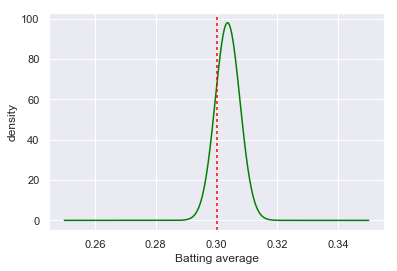

In [17]:
alpha_aaron = batting.loc[batting.name=="Hank Aaron", "alpha_1"]
beta_aaron = batting.loc[batting.name=="Hank Aaron", "beta_1"]
x = np.linspace(0.25,0.35,1000)
pdf_aaron = st.beta.pdf(x,a=alpha_aaron,b=beta_aaron)
ax = sns.lineplot(x,pdf_aaron, color="green")
plt.axvline(0.3,0,100, dashes=[2, 2], color="red")
ax.set(xlabel='Batting average', ylabel='density')

In [18]:
st.beta.cdf(0.3,a=alpha_aaron,b=beta_aaron)

array([0.18493608])

In [20]:
batting["PEP"] = st.beta.cdf(0.3,a=batting["alpha_1"],b=batting["beta_1"])

We can see that most players have a PEP of almost 1:

[Text(0, 0.5, 'density'), Text(0.5, 0, 'PEP')]

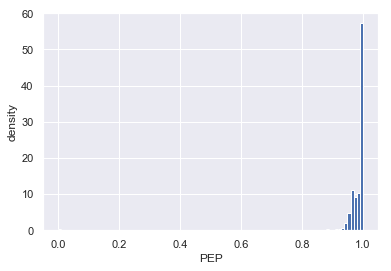

In [60]:
ax = batting["PEP"].hist(bins=100, density=True)
ax.set(xlabel='PEP', ylabel='density')

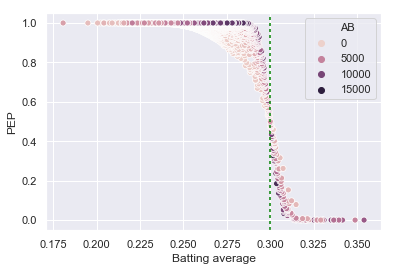

In [68]:
ax = sns.scatterplot(batting["eb_estimate"], batting["PEP"], hue=batting["AB"])
ax.set(xlabel='Batting average', ylabel='PEP')
plt.axvline(0.3,0,100, dashes=[2, 2], color="green")

In [36]:
top_players = batting.sort_values("PEP").head(100)

The false discovery rate (FDR) when including the first 100 players would be 5.93%:

In [37]:
top_players.PEP.sum()

5.9297100246041605

In [38]:
top_players.PEP.mean()

0.0592971002460416

We can quickly print some FDRs for other values of included players:

In [46]:
for n in [10, 50, 100, 150, 200]:
    temp = batting.sort_values("PEP").head(n)
    print(n, "%.3f" % temp.PEP.mean())

10 0.000
50 0.002
100 0.059
150 0.164
200 0.272


We can make this a little bit more formal and automatic: We will sort the whole data frame by PEP and use the `expanding` functionality from Pandas and calculate the cumulative mean of the `PEP`-column. This is called the `q-value`. This q-value can be used to control the false discovery rate (FDR).

In [51]:
batting = batting.sort_values("PEP")
batting["cum_pep_mean"] = batting["PEP"].expanding(1).mean()

In [69]:
batting.head(10)

,playerID,AB,H,average,name,eb_estimate,alpha_1,beta_1,PEP,cum_pep_mean
4033,hornsro01,8173,2930,0.358497,Rogers Hornsby,0.354065,3031.4,5530.3,3.100352e-27,3.100352e-27
2159,delahed01,7510,2597,0.345806,Ed Delahanty,0.341626,2698.4,5200.3,7.806414e-16,3.903207e-16
4514,keelewi01,8591,2932,0.341287,Willie Keeler,0.337806,3033.4,5946.3,5.453547e-15,2.078063e-15
4216,jacksjo01,4981,1772,0.355752,Shoeless Joe Jackson,0.348884,1873.4,3496.3,6.620512e-15,3.213675e-15
4827,lajoina01,9590,3243,0.338165,Nap Lajoie,0.335154,3344.4,6634.3,1.717115e-14,6.005171e-15
3489,gwynnto01,9288,3141,0.338178,Tony Gwynn,0.335073,3242.4,6434.3,4.734851e-14,1.289573e-14
3754,heilmha01,7787,2660,0.341595,Harry Heilmann,0.337757,2761.4,5414.3,8.901185e-14,2.376946e-14
3079,gehrilo01,8001,2721,0.340082,Lou Gehrig,0.336413,2822.4,5567.3,3.075781e-13,5.924553e-14
3559,hamilbi01,6283,2164,0.344421,Billy Hamilton,0.339554,2265.4,4406.3,1.638891e-12,2.347617e-13
1680,collied01,9949,3315,0.333199,Eddie Collins,0.330480,3416.4,6921.3,1.052787e-11,1.264073e-12


In [54]:
hall_of_fame = batting.loc[batting["cum_pep_mean"]< 0.05]

In [55]:
hall_of_fame.shape

(94, 10)

We can plot the number of players for each q-value threshold:

[Text(0, 0.5, 'Number of included players'), Text(0.5, 0, 'q-value threshold')]

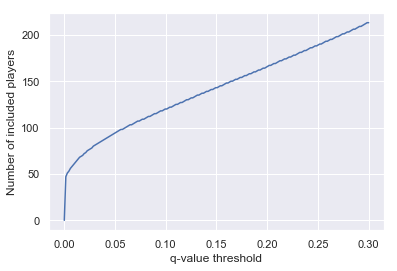

In [70]:
value_list = []
for perc in np.linspace(0, 0.3, 200):
    value_list.append(batting.loc[batting["cum_pep_mean"]< perc].shape[0])
    
ax = sns.lineplot(np.linspace(0, 0.3, 200), value_list)
ax.set(xlabel='q-value threshold', ylabel='Number of included players')